# 1. 환경 세팅 및 데이터 다운로드

In [39]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AIFFEL/Deep_Dive/work/make_vocab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AIFFEL/Deep_Dive/work/make_vocab


In [40]:
!pip install konlpy
!pip install sentencepiece
!pip install soynlp
!apt-get install -y openjdk-17-jdk
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd ./Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh
%cd /content/drive/MyDrive/AIFFEL/Deep_Dive/work/make_vocab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jdk is already the newest version (17.0.16+8~us1-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.
/content/drive/MyDrive/AIFFEL/Deep_Dive/work/make_vocab/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-11-13 07:54:17--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.142.25, 104.192.142.26, 104.192.142.24, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.142.25|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.

In [41]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin")


In [42]:
import os

import matplotlib.pyplot as plt
import torch
import numpy as np

%matplotlib inline

# 2. 데이터 분석

In [43]:
import os
import pandas as pd

base_path = "/content/drive/MyDrive/AIFFEL/work/sentiment_classification/data/"
raw_train = pd.read_table(base_path + 'ratings_train.txt')
raw_test = pd.read_table(base_path + 'ratings_test.txt')

raw_train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [44]:
raw_test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 결측치 처리

In [45]:
print("train 결측치 처리 전")
print(raw_train.isnull().sum())
print(raw_train[raw_train.isnull().any(axis=1)].head())
train_data = raw_train
train_data['document'] = train_data['document'].fillna('')

print("="*50)

print("train 결측치 처리 후")
print(train_data.isnull().sum())
print(train_data[train_data.isnull().any(axis=1)].head())

train 결측치 처리 전
id          0
document    5
label       0
dtype: int64
             id document  label
25857   2172111      NaN      1
55737   6369843      NaN      1
110014  1034280      NaN      0
126782  5942978      NaN      0
140721  1034283      NaN      0
train 결측치 처리 후
id          0
document    0
label       0
dtype: int64
Empty DataFrame
Columns: [id, document, label]
Index: []


In [46]:
print("test 결측치 처리 전")
print(raw_test.isnull().sum())
print(raw_test[raw_train.isnull().any(axis=1)].head())
test_data = raw_test
test_data['document'] = test_data['document'].fillna('')

print("="*50)

print("test 결측치 처리 후")
print(test_data.isnull().sum())
print(test_data[train_data.isnull().any(axis=1)].head())

test 결측치 처리 전
id          0
document    3
label       0
dtype: int64
Empty DataFrame
Columns: [id, document, label]
Index: []
test 결측치 처리 후
id          0
document    0
label       0
dtype: int64
Empty DataFrame
Columns: [id, document, label]
Index: []


/tmp/ipython-input-2986361469.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(raw_test[raw_train.isnull().any(axis=1)].head())
/tmp/ipython-input-2986361469.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(test_data[train_data.isnull().any(axis=1)].head())


## 전처리

In [47]:
import re

# 불용어 리스트
STOPWORDS = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 맞춤법 변형 사전
SPELLING_DICT = {
    '굳': ['궅', '굳', '굿'],
    '미쳤': ['미첫', '미쳣', '미첬', '미쳤', 'ㅁㅊ'],
    '괜찮': ['괜찮', '괜춘', '괜찬', 'ㄱㅊ', '갠찬', '갠찮', '괸찬', '괸찮'],
    '봤': ['봣'],
    '겠': ['겟']
}

# 텍스트 컬럼명
TEXT_COL = "document"

def preprocess_text(text):
    """
    텍스트 전처리 함수
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # 1. 반복되는 문장 부호 제거 (2개 이상 → 1개)
    text = re.sub(r'([.!?…;])\1+', r'\1', text)

    # 2. 맞춤법 변형 통일
    for correct, variations in SPELLING_DICT.items():
        for variant in variations:
            text = text.replace(variant, correct)

    # 3. 반복 문자 제거 (3번 이상 반복 → 2번)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # 4. 자음/모음 단독 제거 (완성형 한글 필터링 전에 먼저 제거)
    # 한글 자음: ㄱ-ㅎ, 한글 모음: ㅏ-ㅣ
    text = re.sub(r'[ㄱ-ㅎㅏ-ㅣ]+', ' ', text)

    # 5. 영어/숫자/한글/문장부호만 남기고 모두 삭제
    # 이모지, 이모티콘, 특수문자 자동 제거
    text = re.sub(r'[^가-힣a-zA-Z0-9\s.!?,]', ' ', text)

    # 6. 문장부호 앞뒤로 공백 추가
    text = re.sub(r'([.!?,])', r' \1 ', text)

    # 7. 영어 소문자 변환
    text = text.lower()

    # 9. 불용어 제거 (조사가 붙은 경우도 처리)
    words = text.split()
    # 디버깅: 불용어 제거 전후 비교
    # print(f"불용어 제거 전: {words}")

    # 단어 끝에 불용어가 붙어있으면 제거
    filtered_words = []
    for word in words:
        # 단어 전체가 불용어인 경우
        if word in STOPWORDS:
            continue
        # 단어 끝에서 불용어 제거 (가장 긴 것부터 체크)
        # 예: "학교에서" -> "학교", "영화는" -> "영화"
        found = False
        for stopword in sorted(STOPWORDS, key=len, reverse=True):
            if len(word) > len(stopword) and word.endswith(stopword):
                cleaned = word[:-len(stopword)]
                # 남은 부분이 2글자 이상일 때만 제거
                # 굳이 -> 굳, 같이 -> 같  이렇게 바뀌어서 길이 제한 추가했습니다.
                # "굳이" -> "굳" (X), "영화는" -> "영화" (O)
                if len(cleaned) >= 2:
                    filtered_words.append(cleaned)
                    found = True
                    break
        if not found:
            filtered_words.append(word)

    text = ' '.join(filtered_words)

    # 10. 연속 공백을 하나의 공백으로 교체
    text = re.sub(r'\s+', ' ', text)

    # 11. 앞뒤 공백 제거
    text = text.strip()

    return text


def preprocess_dataframe(df, text_col=TEXT_COL):
    """
    데이터프레임 전처리 함수
    """
    print(f"전처리 전 데이터 크기: {len(df)}")

    # 1. 결측치 제거
    df = df.dropna(subset=[text_col])
    print(f"결측치 제거 후: {len(df)}")

    # 2. 텍스트 전처리 적용
    df[text_col] = df[text_col].apply(preprocess_text)

    # 3. 전처리 후 빈 문자열 제거
    df = df[df[text_col].str.strip() != '']
    print(f"빈 문자열 제거 후: {len(df)}")

    # 4. 중복 행 제거
    df = df.drop_duplicates(subset=[text_col])
    print(f"중복 제거 후: {len(df)}")

    # 인덱스 재설정
    df = df.reset_index(drop=True)

    return df


# 샘플 텍스트로 테스트
sample_texts = [
    "어제 본 영화 진짜 재밌었음!!! 또 보고 싶어 😂",
    "나는 오늘 아침에 학교에 갔다. 근데 너무 졸렸음ㅋㅋㅋㅋ",
    "밥은 먹었니?? 아직이야... 점심에 같이 먹자!!!",
    "메캅 형태소 분석은 한국어 처리에서 많이 사용돼 👍",
    "파이썬으로 토큰 빈도와 품사 분포를 시각화해 보자!!!",
    "요즘 코사인 유사도 기반 벡터 검색으로 RG 구축을 많이 해!!",
    "에이전트는 외부 도구를 호출해 작업을 자동화할 수 있어. 굳!",
    "이 영화 진짜 미쳣다!!! 너무 재밌음ㅋㅋㅋㅋ",
    "배우 연기 굳이 훌륭했음, 스토리는 봣지만...",
    "이건 ㄱㅊ 영화네, 굿굿!"
]

print("=" * 80)
print("샘플 텍스트 전처리 결과")
print("=" * 80)
for i, text in enumerate(sample_texts, 1):
    processed = preprocess_text(text)
    print(f"\n[{i}] 원본: {text}")
    print(f"    결과: {processed}")

print("\n" + "=" * 80)
print("실제 데이터 적용 예시")
print("=" * 80)

train_data = preprocess_dataframe(train_data.copy())
test_data = preprocess_dataframe(test_data.copy())

print("\n전처리 완료!")
print(f"Train 데이터: {len(train_data)}개")
print(f"Test 데이터: {len(test_data)}개")

print("\n전처리 결과 샘플:")
print(train_data.head(10))

샘플 텍스트 전처리 결과

[1] 원본: 어제 본 영화 진짜 재밌었음!!! 또 보고 싶어 😂
    결과: 어제 본 영화 진짜 재밌었음 ! 또 보고 싶어

[2] 원본: 나는 오늘 아침에 학교에 갔다. 근데 너무 졸렸음ㅋㅋㅋㅋ
    결과: 나는 오늘 아침 학교 갔다 . 근데 너무 졸렸음

[3] 원본: 밥은 먹었니?? 아직이야... 점심에 같이 먹자!!!
    결과: 밥은 먹었니 ? 아직이야 . 점심 같이 먹자 !

[4] 원본: 메캅 형태소 분석은 한국어 처리에서 많이 사용돼 👍
    결과: 메캅 형태소 분석 한국어 처리에서 많이 사용돼

[5] 원본: 파이썬으로 토큰 빈도와 품사 분포를 시각화해 보자!!!
    결과: 파이썬 토큰 빈도 품사 분포 시각화해 보자 !

[6] 원본: 요즘 코사인 유사도 기반 벡터 검색으로 RG 구축을 많이 해!!
    결과: 요즘 코사인 유사 기반 벡터 검색 rg 구축을 많이 해 !

[7] 원본: 에이전트는 외부 도구를 호출해 작업을 자동화할 수 있어. 굳!
    결과: 에이전트 외부 도구 호출해 작업을 자동화할 수 있어 . 굳 !

[8] 원본: 이 영화 진짜 미쳣다!!! 너무 재밌음ㅋㅋㅋㅋ
    결과: 영화 진짜 미쳤다 ! 너무 재밌음

[9] 원본: 배우 연기 굳이 훌륭했음, 스토리는 봣지만...
    결과: 배우 연기 굳이 훌륭했음 , 스토리 봤지만 .

[10] 원본: 이건 ㄱㅊ 영화네, 굿굿!
    결과: 이건 괜찮 영화네 , 굳굳 !

실제 데이터 적용 예시
전처리 전 데이터 크기: 150000
결측치 제거 후: 150000
빈 문자열 제거 후: 149607
중복 제거 후: 144478
전처리 전 데이터 크기: 50000
결측치 제거 후: 50000
빈 문자열 제거 후: 49843
중복 제거 후: 48700

전처리 완료!
Train 데이터: 144478개
Test 데이터: 48700개

전처리 결과 샘플:
         id                                       

## 데이터 시각화 및 통계

문장의 최단 길이: 1
문장의 최장 길이: 163
문장의 평균 길이: 33
문장의 coverage가 50% 인 길이:  43
문장의 coverage가 60% 인 길이:  54
문장의 coverage가 70% 인 길이:  74
문장의 coverage가 80% 인 길이:  97
문장의 coverage가 90% 인 길이:  123
문장의 coverage가 95% 인 길이:  131
문장의 coverage가 99% 인 길이:  139
144478


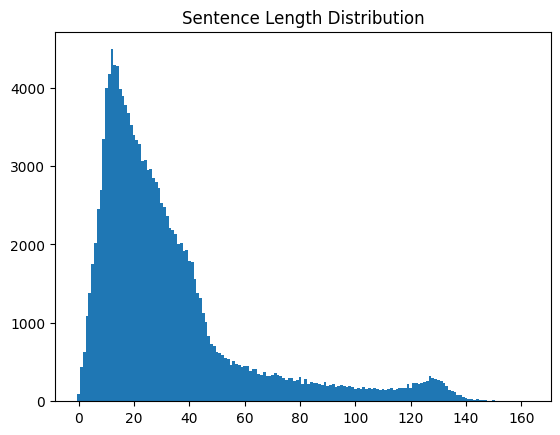

In [48]:
min_len = 999
max_len = 0
sum_len = 0
thr_len = []
percent = [50, 60, 70, 80, 90, 95, 99]
len_list = []

for i in range(len(train_data)):
    sen = train_data['document'][i]
    length = len(train_data['document'][i])
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    len_list.append(length)

len_list.sort()

# XX% coverage -> sentence_lenght 사용해서 다시 진행 필요
threshold = []
for perc in percent:
    threshold.append(sum_len * (perc/100))

for thr in threshold:
    thr_sum = 0
    for length in len_list:
        thr_sum += length
        if thr_sum > thr:
            thr_len.append(length)
            break

coverage_dict = dict(zip(percent, thr_len))

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data))
for p, l in coverage_dict.items():
    print("문장의 coverage가 "+ str(p) +"% 인 길이: ", l)

sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

print(len(train_data))

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [49]:
def check_sentence_with_length(raw, length, max_print=100):
    """
    지정된 길이의 문장을 최대 max_print개까지 출력합니다.
    NaN 또는 비문자열은 자동으로 건너뜁니다.
    """
    count = 0

    for sen in raw:
        if not isinstance(sen, str):  # NaN 등 비문자열 제외
            continue

        if len(sen) == length:
            print(sen)
            count += 1
            if count >= max_print:  # 100개 이상이면 종료
                break

    if count == 0:
        print(f"길이가 {length}인 문장은 없습니다.")

    print(count)

check_sentence_with_length(train_data['document'], 0)

길이가 0인 문장은 없습니다.
0


In [50]:
# 데이터 중간에 비이상적으로 많은 값 확인 목적

# for idx, _sum in enumerate(sentence_length):
#     # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
#     if _sum > 5000:
#         print("Outlier Index:", idx+1)

문장의 최단 길이: 1
문장의 최장 길이: 163
문장의 평균 길이: 33
문장의 coverage가 50% 인 길이:  43
문장의 coverage가 60% 인 길이:  54
문장의 coverage가 70% 인 길이:  74
문장의 coverage가 80% 인 길이:  97
문장의 coverage가 90% 인 길이:  123
문장의 coverage가 95% 인 길이:  131
문장의 coverage가 99% 인 길이:  139
144478


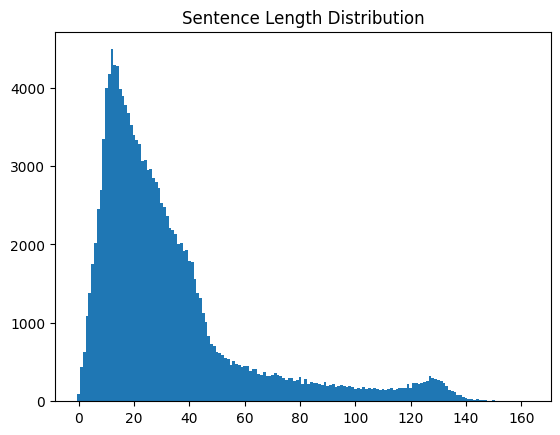

In [51]:
cleaned_corpus = train_data.drop_duplicates(subset=['document']).reset_index(drop=True)

min_len = 999
max_len = 0
sum_len = 0
thr_len = []
percent = [50, 60, 70, 80, 90, 95, 99]
len_list = []

for i in range(len(train_data)):
    sen = train_data['document'][i]
    length = len(train_data['document'][i])
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    len_list.append(length)

len_list.sort()

# XX% coverage -> sentence_lenght 사용해서 다시 진행 필요
threshold = []
for perc in percent:
    threshold.append(sum_len * (perc/100))

for thr in threshold:
    thr_sum = 0
    for length in len_list:
        thr_sum += length
        if thr_sum > thr:
            thr_len.append(length)
            break

coverage_dict = dict(zip(percent, thr_len))

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data))
for p, l in coverage_dict.items():
    print("문장의 coverage가 "+ str(p) +"% 인 길이: ", l)

sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

print(len(cleaned_corpus))

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

필터링된 문장 수: 142673 / 전체 144478
문장의 최단 길이: 1
문장의 최장 길이: 130
문장의 평균 길이: 32
문장의 coverage가 50%인 길이: 41
문장의 coverage가 60%인 길이: 50
문장의 coverage가 70%인 길이: 66
문장의 coverage가 80%인 길이: 87
문장의 coverage가 90%인 길이: 113
문장의 coverage가 95%인 길이: 124
문장의 coverage가 99%인 길이: 129


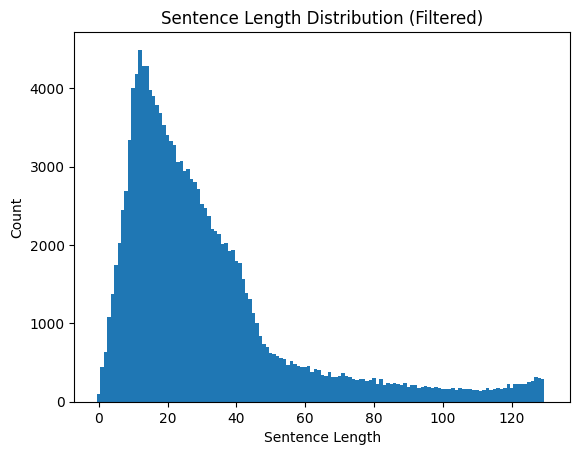

In [52]:
# --- 2️⃣ 길이 필터 적용 ---
max_len = 131
# min_len = 10
min_len = 0


filtered_corpus = [
    s for s in cleaned_corpus['document']
    if isinstance(s, str) and (min_len <= len(s) < max_len)
]

print(f"필터링된 문장 수: {len(filtered_corpus)} / 전체 {len(cleaned_corpus)}")

# --- 3️⃣ 문장 길이 분포 계산 ---
sentence_length = np.zeros((max_len), dtype=int)
len_list = []

for sen in filtered_corpus:
    l = len(sen)
    sentence_length[l - 1] += 1
    len_list.append(l)

# --- 4️⃣ Coverage 계산 ---
len_list.sort()
sum_len = sum(len_list)
percent = [50, 60, 70, 80, 90, 95, 99]
thr_len = []

for p in percent:
    threshold = sum_len * (p / 100)
    thr_sum = 0
    for l in len_list:
        thr_sum += l
        if thr_sum > threshold:
            thr_len.append(l)
            break

coverage_dict = dict(zip(percent, thr_len))

print("문장의 최단 길이:", min(len_list))
print("문장의 최장 길이:", max(len_list))
print("문장의 평균 길이:", sum_len // len(len_list))
for p, l in coverage_dict.items():
    print(f"문장의 coverage가 {p}%인 길이: {l}")

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution (Filtered)")
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.show()

# 3. 공백 기반 토큰화

In [53]:
import torch
from torch.nn.utils.rnn import pad_sequence

class Tokenizer:
    def __init__(self, filters=''):
        self.word_index = {}
        self.index_word = {}
        self.filters = filters

    def fit_on_texts(self, corpus):
        # 각 문장을 토큰화하여 단어 사전을 생성 (인덱스는 1부터 시작)
        for sentence in corpus:
            tokens = sentence.split() if isinstance(sentence, str) else sentence
            for token in tokens:
                if token not in self.word_index:
                    self.word_index[token] = len(self.word_index) + 1
        # 역방향 사전 생성
        self.index_word = {idx: word for word, idx in self.word_index.items()}

    def texts_to_sequences(self, corpus):
        sequences = []
        for sentence in corpus:
            tokens = sentence.split() if isinstance(sentence, str) else sentence
            # 존재하지 않는 단어는 0으로 처리
            seq = [self.word_index.get(token, 0) for token in tokens]
            sequences.append(torch.tensor(seq, dtype=torch.long))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for seq in sequences:
            # tensor인 경우 리스트로 변환
            if isinstance(seq, torch.Tensor):
                seq = seq.tolist()
            # 패딩 토큰(0)은 제외하고 디코딩
            tokens = [self.index_word.get(idx, "") for idx in seq if idx != 0]
            texts.append(tokens)
        return texts

In [54]:
def tokenize(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)
    # padding 토큰은 0
    tensor = pad_sequence(sequences, batch_first=True, padding_value=0)
    return tensor, tokenizer

# 4. 형태소 기반 토큰화

In [55]:
from konlpy.tag import Mecab

mecab = Mecab()

def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [56]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 47326


# 라이브러리 버전 확인

In [57]:
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import konlpy

print(torch.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(konlpy.__version__)

2.8.0+cu126
2.0.2
3.10.0
0.6.0


# SentencePiece 모델 학습

# Tokenizer 함수 작성



In [58]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = pad_sequence(tensor, batch_first=True, padding_value=0)

    return tensor, word_index, index_word

In [59]:
from konlpy.tag import Komoran
from torch.nn.utils.rnn import pad_sequence
import torch

def komoran_tokenize(corpus):
    kom = Komoran()
    tokenized = []

    # 문장별 형태소 단위 토큰화
    for sen in corpus:
        if not isinstance(sen, str):
            continue
        tokens = [word for word, pos in kom.pos(sen, norm=True, stem=True)]
        tokenized.append(tokens)

    # vocab 만들기
    counter = {}
    for toks in tokenized:
        for t in toks:
            counter[t] = counter.get(t, 0) + 1

    vocab = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    word_index = {w: i + 2 for i, (w, _) in enumerate(vocab)}  # +2 for pad/unk
    word_index["<pad>"] = 0
    word_index["<unk>"] = 1
    index_word = {i: w for w, i in word_index.items()}

    # 인덱스 변환
    tensor = []
    for toks in tokenized:
        tensor.append(torch.tensor([word_index.get(t, 1) for t in toks], dtype=torch.long))

    # 패딩
    tensor = pad_sequence(tensor, batch_first=True, padding_value=0)

    return tensor, word_index, index_word


In [60]:
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer

def soynlp_tokenize(corpus):
    # WordExtractor 학습
    extractor = WordExtractor(min_frequency=5)
    extractor.train(corpus)
    word_scores = extractor.extract()
    cohesion = {w: s.cohesion_forward for w, s in word_scores.items()}
    tokenizer = LTokenizer(cohesion)

    tokenized = [tokenizer.tokenize(sen) for sen in corpus if isinstance(sen, str)]

    # vocab 만들기
    counter = {}
    for toks in tokenized:
        for t in toks:
            counter[t] = counter.get(t, 0) + 1

    vocab = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    word_index = {w: i + 2 for i, (w, _) in enumerate(vocab)}  # +2 for pad/unk
    word_index["<pad>"] = 0
    word_index["<unk>"] = 1
    index_word = {i: w for w, i in word_index.items()}

    # 인덱스 변환
    tensor = []
    for toks in tokenized:
        tensor.append(torch.tensor([word_index.get(t, 1) for t in toks], dtype=torch.long))

    tensor = pad_sequence(tensor, batch_first=True, padding_value=0)

    return tensor, word_index, index_word


In [61]:
# ==== Common helpers =========================================================
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import torch
from typing import List, Tuple, Dict, Iterable, Callable, Optional
import os
import tempfile

def _build_vocab_from_token_lists(token_lists: Iterable[List[str]]):
    counter = Counter()
    for toks in token_lists:
        counter.update(toks)
    vocab = [w for w, _ in counter.most_common()]
    word_index = {w: i + 2 for i, w in enumerate(vocab)}  # +2 for <pad>, <unk>
    word_index["<pad>"] = 0
    word_index["<unk>"] = 1
    index_word = {i: w for w, i in word_index.items()}
    return word_index, index_word

def _to_padded_tensor(token_lists: Iterable[List[str]], word_index: Dict[str, int]):
    seqs = [torch.tensor([word_index.get(t, 1) for t in toks], dtype=torch.long)
            for toks in token_lists]
    return pad_sequence(seqs, batch_first=True, padding_value=0)

# Small wrapper to make corpus-level API like your komoran/soynlp ones
def _tokenize_corpus(
    corpus: Iterable[str],
    tokenize_one_fn: Callable[[str], List[str]]
) -> Tuple[torch.Tensor, Dict[str,int], Dict[int,str]]:
    corpus = [s for s in corpus if isinstance(s, str) and s.strip()]
    token_lists = [tokenize_one_fn(s) for s in corpus]
    word_index, index_word = _build_vocab_from_token_lists(token_lists)
    tensor = _to_padded_tensor(token_lists, word_index)
    return tensor, word_index, index_word


In [62]:
# ==== OKT ====================================================================
from konlpy.tag import Okt

_okt_singleton = None
def _get_okt():
    global _okt_singleton
    if _okt_singleton is None:
        _okt_singleton = Okt()
    return _okt_singleton

def okt_tokenize_one(s: str) -> List[str]:
    okt = _get_okt()
    return [w for w, p in okt.pos(s, norm=True, stem=True)]

def okt_pos_pairs_one(s: str):
    okt = _get_okt()
    return okt.pos(s, norm=True, stem=True)

def okt_tokenize(corpus):
    return _tokenize_corpus(corpus, okt_tokenize_one)


In [63]:
# ==== Hannanum ===============================================================
from konlpy.tag import Hannanum

_hannanum_singleton = None
def _get_hannanum():
    global _hannanum_singleton
    if _hannanum_singleton is None:
        _hannanum_singleton = Hannanum()
    return _hannanum_singleton

def hannanum_tokenize_one(s: str) -> List[str]:
    han = _get_hannanum()
    # Hannanum.pos returns list[(token, tag)]
    return [w for w, p in han.pos(s)]

def hannanum_pos_pairs_one(s: str):
    han = _get_hannanum()
    return han.pos(s)

def hannanum_tokenize(corpus):
    return _tokenize_corpus(corpus, hannanum_tokenize_one)


In [64]:
# ==== Kkma ===================================================================
from konlpy.tag import Kkma

_kkma_singleton = None
def _get_kkma():
    global _kkma_singleton
    if _kkma_singleton is None:
        _kkma_singleton = Kkma()
    return _kkma_singleton

def kkma_tokenize_one(s: str) -> List[str]:
    kk = _get_kkma()
    return [w for w, p in kk.pos(s)]

def kkma_pos_pairs_one(s: str):
    kk = _get_kkma()
    return kk.pos(s)

def kkma_tokenize(corpus):
    return _tokenize_corpus(corpus, kkma_tokenize_one)


In [65]:
# ==== Mecab (konlpy) =========================================================
# Make sure mecab-ko is installed. If not available via konlpy, fall back gracefully.
try:
    from konlpy.tag import Mecab
    _mecab_singleton = None
    def _get_mecab():
        global _mecab_singleton
        if _mecab_singleton is None:
            _mecab_singleton = Mecab()
        return _mecab_singleton

    def mecab_tokenize_one(s: str) -> List[str]:
        mc = _get_mecab()
        return [w for w, p in mc.pos(s)]

    def mecab_pos_pairs_one(s: str):
        mc = _get_mecab()
        return mc.pos(s)

    def mecab_tokenize(corpus):
        return _tokenize_corpus(corpus, mecab_tokenize_one)

except Exception as e:
    # Optional stub if Mecab not available
    def mecab_tokenize_one(s: str) -> List[str]:
        raise RuntimeError("Mecab not available via konlpy. Install mecab-ko & konlpy Mecab.") from e
    def mecab_pos_pairs_one(s: str):
        return None
    def mecab_tokenize(corpus):
        raise RuntimeError("Mecab not available via konlpy. Install mecab-ko & konlpy Mecab.") from e


In [66]:
# ==== SentencePiece (Unigram/BPE, separate prefix version) ====================
import os, tempfile
from typing import Iterable, Optional, List, Callable, Tuple
import sentencepiece as spm
from torch.nn.utils.rnn import pad_sequence
import torch

# -------------------------------------------------------------------
# 1) Train
# -------------------------------------------------------------------
def spm_train_model_from_corpus(
    corpus: Iterable[str],
    model_prefix: str,
    vocab_size: int = 8000,
    model_type: str = "unigram",  # "unigram" or "bpe"
    character_coverage: float = 0.9995,
    user_defined_symbols: Optional[List[str]] = None,
    add_bos_eos: bool = False,
) -> str:
    """
    Writes a temp txt, trains SPM, returns model path '<prefix>.model'
    """
    corpus = [s for s in corpus if isinstance(s, str) and s.strip()]
    if not corpus:
        raise ValueError("Empty corpus for SentencePiece training.")

    os.makedirs(os.path.dirname(model_prefix) or ".", exist_ok=True)
    tmp_txt = model_prefix + ".txt"
    with open(tmp_txt, "w", encoding="utf-8") as f:
        for line in corpus:
            f.write(line.replace("\n", " ").strip() + "\n")

    uds = ",".join(user_defined_symbols) if user_defined_symbols else ""
    args = [
        f"--input={tmp_txt}",
        f"--model_prefix={model_prefix}",
        f"--vocab_size={vocab_size}",
        f"--model_type={model_type}",
        f"--character_coverage={character_coverage}",
        "--pad_id=-1",  # manage <pad> manually
    ]
    if uds:
        args.append(f"--user_defined_symbols={uds}")
    if add_bos_eos:
        args.append("--bos_id=1")
        args.append("--eos_id=2")
    else:
        args.append("--bos_id=-1")
        args.append("--eos_id=-1")

    spm.SentencePieceTrainer.Train(" ".join(args))
    return model_prefix + ".model"

# -------------------------------------------------------------------
# 2) Helpers
# -------------------------------------------------------------------
def spm_load(model_path: str) -> spm.SentencePieceProcessor:
    sp = spm.SentencePieceProcessor()
    sp.Load(model_path)
    return sp

def spm_tokenize_one(sp: spm.SentencePieceProcessor, s: str) -> List[str]:
    return sp.EncodeAsPieces(s)

def spm_build_word_index_from_model(sp: spm.SentencePieceProcessor):
    size = sp.GetPieceSize()
    pieces = [sp.IdToPiece(i) for i in range(size)]
    core = [p for p in pieces if p != "<unk>"]
    word_index = {w: i + 2 for i, w in enumerate(core)}
    word_index["<pad>"] = 0
    word_index["<unk>"] = 1
    index_word = {i: w for w, i in word_index.items()}
    return word_index, index_word

# -------------------------------------------------------------------
# 3) Main function
# -------------------------------------------------------------------
def sentencepiece_tokenize(
    corpus: Iterable[str],
    model_type: str = "unigram",  # or "bpe"
    vocab_size: int = 8000,
    character_coverage: float = 0.9995,
    user_defined_symbols: Optional[List[str]] = None,
    add_bos_eos: bool = False,
    output_dir: str = "./spm_models",
):
    """
    Train and tokenize with SentencePiece.
    Each model_type automatically uses a distinct prefix under output_dir.
    """
    os.makedirs(output_dir, exist_ok=True)
    model_prefix = os.path.join(output_dir, f"ko_{model_type}_{vocab_size}")
    model_path = model_prefix + ".model"

    if not os.path.exists(model_path):
        model_path = spm_train_model_from_corpus(
            corpus=corpus,
            model_prefix=model_prefix,
            vocab_size=vocab_size,
            model_type=model_type,
            character_coverage=character_coverage,
            user_defined_symbols=user_defined_symbols,
            add_bos_eos=add_bos_eos,
        )

    sp = spm_load(model_path)
    corpus = [s for s in corpus if isinstance(s, str) and s.strip()]
    token_lists = [sp.EncodeAsPieces(s) for s in corpus]

    word_index, index_word = spm_build_word_index_from_model(sp)
    seqs = [torch.tensor([word_index.get(t, 1) for t in toks], dtype=torch.long)
            for toks in token_lists]
    tensor = pad_sequence(seqs, batch_first=True, padding_value=0)
    return tensor, word_index, index_word, model_path, sp

# -------------------------------------------------------------------
# 4) Wrapper shortcuts
# -------------------------------------------------------------------
def sentencepiece_unigram_tokenize(corpus, **kwargs):
    return sentencepiece_tokenize(corpus, model_type="unigram", **kwargs)

def sentencepiece_bpe_tokenize(corpus, **kwargs):
    return sentencepiece_tokenize(corpus, model_type="bpe", **kwargs)

# -------------------------------------------------------------------
# 5) analyze_tokenizer용 단일 문장 함수
# -------------------------------------------------------------------
def spm_make_tokenize_one(model_path: str) -> Callable[[str], List[str]]:
    sp = spm_load(model_path)
    def _fn(s: str) -> List[str]:
        return sp.EncodeAsPieces(s)
    return _fn

def spm_pos_pairs_one(_unused: str):
    return None  # SentencePiece는 품사 정보 없음


In [67]:
from collections import Counter
import numpy as np

def analyze_tokenizer(
    corpus,
    tokenize_one_fn,                 # (str) -> list[str]
    pos_pairs_one_fn=None,           # (str) -> list[(token, pos)] | None
    top_n=20,
    coverages=(0.9, 0.95, 0.99),
    example_sentences=None,          # ✅ 새로 추가: 예시 문장 리스트
    title="Tokenizer Report",
):
    """
    - 코퍼스로 통계/coverage/상위 토큰 계산
    - 예시 문장은 example_sentences로 별도 받아 토큰화 결과만 출력
    """
    # 0) 코퍼스 정리
    corpus = [s for s in corpus if isinstance(s, str) and s.strip()]
    if not corpus:
        print(f"[{title}] 빈 코퍼스입니다.")
        return {}

    # 1) 코퍼스 토큰화
    token_lists = [tokenize_one_fn(s) for s in corpus]
    flat_tokens = [t for toks in token_lists for t in toks]

    # 2) 기본 통계
    total_tokens = len(flat_tokens)
    avg_tokens_per_sent = float(np.mean([len(toks) for toks in token_lists])) if token_lists else 0.0
    avg_token_char_len = float(np.mean([len(t) for t in flat_tokens])) if flat_tokens else 0.0

    # 3) 품사 비율 (옵션)
    pos_ratio = None
    if pos_pairs_one_fn is not None:
        pos_counter = Counter()
        for s in corpus:
            pairs = pos_pairs_one_fn(s) or []
            pos_counter.update([p for _, p in pairs])
        total_pos = sum(pos_counter.values())
        if total_pos > 0:
            pos_ratio = {p: round(c / total_pos, 4) for p, c in pos_counter.items()}

    # 4) 상위 토큰
    top_tokens = Counter(flat_tokens).most_common(top_n)

    # 5) coverage 기반 vocab size
    freq = Counter(flat_tokens)
    total_freq = sum(freq.values())
    sorted_items = freq.most_common()
    suggested_vocab_size = {}
    for cov in coverages:
        need = total_freq * cov
        acc = 0
        k = 0
        for _, c in sorted_items:
            acc += c
            k += 1
            if acc >= need:
                suggested_vocab_size[cov] = k
                break

    # 6) 요약 출력
    print(f"\n[{title}] 요약")
    print(f"- 전체 문장 수: {len(corpus)}")
    print(f"- 전체 토큰 수: {total_tokens}")
    print(f"- 문장당 평균 토큰 수: {avg_tokens_per_sent:.2f}")
    print(f"- 평균 토큰 '문자' 길이: {avg_token_char_len:.2f}")
    if pos_ratio is not None:
        print("- 품사 비율:")
        for p, r in sorted(pos_ratio.items(), key=lambda x: (-x[1], x[0])):
            print(f"  • {p}: {r:.4f}")

    print(f"\n- 상위 {top_n} 토큰:")
    for tok, cnt in top_tokens:
        print(f"  • \"{tok}\" {cnt}개")

    print("\n- coverage 기준 vocab size 제안:")
    for cov in coverages:
        k = suggested_vocab_size.get(cov, 0)
        print(f"  • {int(cov*100)}% → {k}")

    # 7) 예시 문장 토큰화 (코퍼스와 별개로 처리) ✅
    if example_sentences:
        print(f"\n- 예시 문장 {min(len(example_sentences), 5)}개 토큰화:")
        for i, s in enumerate(example_sentences[:5], 1):
            print(f"  {i}. {s}")
            toks = tokenize_one_fn(s)
            if pos_pairs_one_fn is not None:
                pairs = pos_pairs_one_fn(s) or []
                print("     -> tokens:", toks)
                print("     -> pos   :", pairs)
            else:
                print("     ->", toks)

    # 8) 머신 친화 반환
    return {
        "total_tokens": total_tokens,
        "avg_tokens_per_sentence": avg_tokens_per_sent,
        "avg_token_char_length": avg_token_char_len,
        "pos_ratio": pos_ratio,
        "top_tokens": top_tokens,
        "suggested_vocab_size": suggested_vocab_size,
        "examples": [
            (s, tokenize_one_fn(s),
             (pos_pairs_one_fn(s) if pos_pairs_one_fn else None))
            for s in (example_sentences[:5] if example_sentences else [])
        ],
    }


In [68]:
example_sents = ["오늘 날씨가 정말 좋네요.",
             "저는 자연어 처리를 공부하고 있습니다.",
             "ELMo와 BERT는 문맥 기반 임베딩 모델입니다.",
             "파이썬으로 데이터를 전처리하고 시각화합니다.",
             "모델 성능을 높이기 위해 하이퍼파라미터를 조정합니다."]

In [69]:
# s = spm.SentencePieceProcessor(); s.Load('korean_spm.model')

# spm_tokenize_one = lambda text: s.EncodeAsPieces(text)

# _ = analyze_tokenizer(
#     corpus=filtered_corpus,
#     tokenize_one_fn=spm_tokenize_one,
#     pos_pairs_one_fn=None,              # SP는 품사 없음
#     example_sentences=example_sents,
#     title="SentencePiece"
# )


In [70]:
from konlpy.tag import Komoran
kom = Komoran()

# (필터링된 토큰)과 (품사쌍) 둘 다 준비
def komoran_tokens(text, include_pos=("NNG","NNP","VV","VA","MAG","MAJ")):
    pairs = kom.pos(text)
    return [w for (w, p) in pairs if p in include_pos]

def komoran_pos_pairs(text):
    return kom.pos(text)  # 품사 비율 계산용

_ = analyze_tokenizer(
    corpus=filtered_corpus,
    tokenize_one_fn=komoran_tokens,
    pos_pairs_one_fn=komoran_pos_pairs,
    example_sentences=example_sents,
    title="Komoran"
)



[Komoran] 요약
- 전체 문장 수: 142673
- 전체 토큰 수: 1135037
- 문장당 평균 토큰 수: 7.96
- 평균 토큰 '문자' 길이: 1.87
- 품사 비율:
  • NNG: 0.1698
  • EC: 0.1338
  • NNP: 0.1154
  • VV: 0.0911
  • SF: 0.0640
  • MAG: 0.0494
  • ETM: 0.0464
  • VA: 0.0402
  • NNB: 0.0362
  • EP: 0.0274
  • JX: 0.0209
  • VX: 0.0192
  • VCP: 0.0188
  • JKB: 0.0164
  • XSV: 0.0154
  • ETN: 0.0141
  • XSN: 0.0139
  • NP: 0.0123
  • MM: 0.0119
  • XR: 0.0116
  • JKO: 0.0109
  • SN: 0.0100
  • XSA: 0.0092
  • SP: 0.0080
  • NA: 0.0072
  • SL: 0.0050
  • JKS: 0.0046
  • MAJ: 0.0039
  • VCN: 0.0027
  • JC: 0.0023
  • NR: 0.0023
  • XPN: 0.0022
  • IC: 0.0018
  • JKG: 0.0012
  • JKV: 0.0003
  • EF: 0.0002
  • JKC: 0.0001
  • SW: 0.0000

- 상위 20 토큰:
  • "영화" 51464개
  • "보" 39216개
  • "하" 18155개
  • "없" 16801개
  • "있" 12292개
  • "좋" 11413개
  • "너무" 10421개
  • "정말" 9316개
  • "진짜" 7957개
  • "재밌" 7944개
  • "안" 7706개
  • "연기" 6882개
  • "같" 6704개
  • "만들" 6665개
  • "평점" 5969개
  • "최고" 5909개
  • "되" 5753개
  • "왜" 5659개
  • "나오" 5567개
  • "다" 5146개

In [71]:
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer

# soynlp 토크나이저 학습 (코퍼스 크기에 비례해 시간 걸릴 수 있음)
extractor = WordExtractor(min_frequency=5)
extractor.train(filtered_corpus)
word_scores = extractor.extract()
cohesion = {w: s.cohesion_forward for w, s in word_scores.items()}
soy_tokenizer = LTokenizer(cohesion)

soy_tokenize_one = lambda text: soy_tokenizer.tokenize(text)

_ = analyze_tokenizer(
    corpus=filtered_corpus,
    tokenize_one_fn=soy_tokenize_one,
    pos_pairs_one_fn=None,
    example_sentences=example_sents,
    title="soynlp"
)

# 기본적으로 품사 없음
# 품사 추출기 사용을 위해서는 사전에 정의된 dict 필요

training was done. used memory 2.866 Gb
all cohesion probabilities was computed. # words = 61951
all branching entropies was computed # words = 77181
all accessor variety was computed # words = 77181

[soynlp] 요약
- 전체 문장 수: 142673
- 전체 토큰 수: 1540858
- 문장당 평균 토큰 수: 10.80
- 평균 토큰 '문자' 길이: 2.29

- 상위 20 토큰:
  • "." 124359개
  • "영화" 43691개
  • "," 19315개
  • "!" 16563개
  • "?" 13730개
  • "너무" 11177개
  • "재미" 10058개
  • "다" 9707개
  • "정말" 9240개
  • "을" 8429개
  • "재밌" 7551개
  • "진짜" 7533개
  • "연기" 6994개
  • "고" 6700개
  • "최고" 5856개
  • "평점" 5676개
  • "생각" 4958개
  • "이런" 4885개
  • "스토리" 4865개
  • "게" 4539개

- coverage 기준 vocab size 제안:
  • 90% → 26877
  • 95% → 81567
  • 99% → 143201

- 예시 문장 5개 토큰화:
  1. 오늘 날씨가 정말 좋네요.
     -> ['오늘', '날씨가', '정말', '좋네요', '.']
  2. 저는 자연어 처리를 공부하고 있습니다.
     -> ['저는', '자연', '어', '처리를', '공부하고', '있습니다', '.']
  3. ELMo와 BERT는 문맥 기반 임베딩 모델입니다.
     -> ['ELMo와', 'BERT는', '문맥', '기반', '임베딩', '모델입니다.']
  4. 파이썬으로 데이터를 전처리하고 시각화합니다.
     -> ['파이', '썬으로', '데이', '터를', '전

In [72]:
stats_mecab = analyze_tokenizer(
    corpus=filtered_corpus,
    tokenize_one_fn=mecab_tokenize_one,
    pos_pairs_one_fn=mecab_pos_pairs_one,
    example_sentences=example_sents,
    title="Mecab Report"
)



[Mecab Report] 요약
- 전체 문장 수: 142673
- 전체 토큰 수: 2228335
- 문장당 평균 토큰 수: 15.62
- 평균 토큰 '문자' 길이: 1.59
- 품사 비율:
  • NNG: 0.2494
  • EC: 0.0796
  • MAG: 0.0671
  • SF: 0.0595
  • VV: 0.0525
  • VA: 0.0392
  • EF: 0.0311
  • NNP: 0.0293
  • NNB: 0.0221
  • ETM: 0.0211
  • JKB: 0.0187
  • XSN: 0.0174
  • JX: 0.0156
  • VX: 0.0155
  • MM: 0.0142
  • VV+EC: 0.0133
  • EP: 0.0128
  • VV+ETM: 0.0128
  • SN: 0.0122
  • NP: 0.0110
  • XR: 0.0108
  • JKO: 0.0107
  • NNBC: 0.0107
  • SY: 0.0105
  • VCP: 0.0087
  • XSV: 0.0086
  • SC: 0.0081
  • JKS: 0.0077
  • IC: 0.0074
  • VV+EP: 0.0073
  • ETN: 0.0071
  • VCP+EC: 0.0061
  • XSA: 0.0057
  • VA+ETM: 0.0056
  • SL: 0.0055
  • VCP+EF: 0.0051
  • MAJ: 0.0039
  • VCP+ETM: 0.0039
  • VX+EP: 0.0036
  • NR: 0.0034
  • VV+EF: 0.0032
  • VX+ETM: 0.0032
  • XSV+EC: 0.0030
  • XPN: 0.0026
  • XSA+ETM: 0.0026
  • XSV+ETM: 0.0025
  • JC: 0.0022
  • NP+JX: 0.0022
  • JKG: 0.0020
  • VCN: 0.0020
  • NNB+JKS: 0.0019
  • UNKNOWN: 0.0017
  • VX+EC: 0.0016
  • XSA+ETN

In [73]:
# Unigram
tensor_uni, wi_uni, iw_uni, uni_model_path, sp_uni = sentencepiece_unigram_tokenize(
    corpus=filtered_corpus,
    vocab_size=8000,
    output_dir="./spm_models",
    user_defined_symbols=["<sep>", "<lab0>", "<lab1>", "<lab2>"],
)

# Make a tokenize_one_fn bound to the trained model
spm_uni_tokenize_one = spm_make_tokenize_one(uni_model_path)

analyze_tokenizer(
    corpus=filtered_corpus,
    tokenize_one_fn=spm_uni_tokenize_one,
    pos_pairs_one_fn=None,
    example_sentences=example_sents,
    title="SentencePiece Unigram Report"
)



[SentencePiece Unigram Report] 요약
- 전체 문장 수: 142673
- 전체 토큰 수: 2118324
- 문장당 평균 토큰 수: 14.85
- 평균 토큰 '문자' 길이: 2.26

- 상위 20 토큰:
  • "▁." 124359개
  • "▁" 41345개
  • "▁영화" 33856개
  • "▁," 19315개
  • "을" 17031개
  • "▁!" 16563개
  • "고" 14754개
  • "▁?" 13730개
  • "지" 12046개
  • "다" 11866개
  • "이" 11257개
  • "▁너무" 9976개
  • "만" 9110개
  • "▁정말" 8889개
  • "로" 8771개
  • "▁진짜" 7388개
  • "점" 6637개
  • "기" 6627개
  • "가" 6490개
  • "나" 6480개

- coverage 기준 vocab size 제안:
  • 90% → 3907
  • 95% → 5360
  • 99% → 7209

- 예시 문장 5개 토큰화:
  1. 오늘 날씨가 정말 좋네요.
     -> ['▁오늘', '▁날', '씨', '가', '▁정말', '▁좋네요', '.']
  2. 저는 자연어 처리를 공부하고 있습니다.
     -> ['▁저는', '▁자연', '어', '▁', '처리', '를', '▁공부', '하고', '▁있습니다', '.']
  3. ELMo와 BERT는 문맥 기반 임베딩 모델입니다.
     -> ['▁', 'ELM', 'o', '와', '▁', 'BERT', '는', '▁문', '맥', '▁기', '반', '▁임', '베', '딩', '▁', '모델', '입니다', '.']
  4. 파이썬으로 데이터를 전처리하고 시각화합니다.
     -> ['▁파이', '썬', '으로', '▁데', '이', '터', '를', '▁전', '처리', '하고', '▁시각', '화', '합니다', '.']
  5. 모델 성능을 높이기 위해 하이퍼파라미터를 조정합니다.
     ->

{'total_tokens': 2118324,
 'avg_tokens_per_sentence': 14.847406306729374,
 'avg_token_char_length': 2.26325481843193,
 'pos_ratio': None,
 'top_tokens': [('▁.', 124359),
  ('▁', 41345),
  ('▁영화', 33856),
  ('▁,', 19315),
  ('을', 17031),
  ('▁!', 16563),
  ('고', 14754),
  ('▁?', 13730),
  ('지', 12046),
  ('다', 11866),
  ('이', 11257),
  ('▁너무', 9976),
  ('만', 9110),
  ('▁정말', 8889),
  ('로', 8771),
  ('▁진짜', 7388),
  ('점', 6637),
  ('기', 6627),
  ('가', 6490),
  ('나', 6480)],
 'suggested_vocab_size': {0.9: 3907, 0.95: 5360, 0.99: 7209},
 'examples': [('오늘 날씨가 정말 좋네요.',
   ['▁오늘', '▁날', '씨', '가', '▁정말', '▁좋네요', '.'],
   None),
  ('저는 자연어 처리를 공부하고 있습니다.',
   ['▁저는', '▁자연', '어', '▁', '처리', '를', '▁공부', '하고', '▁있습니다', '.'],
   None),
  ('ELMo와 BERT는 문맥 기반 임베딩 모델입니다.',
   ['▁',
    'ELM',
    'o',
    '와',
    '▁',
    'BERT',
    '는',
    '▁문',
    '맥',
    '▁기',
    '반',
    '▁임',
    '베',
    '딩',
    '▁',
    '모델',
    '입니다',
    '.'],
   None),
  ('파이썬으로 데이터를 전처리하고 시각화합니다.',
   ['▁파이',
    

In [74]:
# BPE (다른 prefix로 자동 저장)
tensor_bpe, wi_bpe, iw_bpe, bpe_model_path, sp_bpe = sentencepiece_bpe_tokenize(
    corpus=filtered_corpus,
    vocab_size=8000,
    output_dir="./spm_models",
    user_defined_symbols=["<sep>", "<lab0>", "<lab1>", "<lab2>"],
)

spm_bpe_tokenize_one = spm_make_tokenize_one(bpe_model_path)

analyze_tokenizer(
    corpus=filtered_corpus,
    tokenize_one_fn=spm_bpe_tokenize_one,
    pos_pairs_one_fn=None,
    example_sentences=example_sents,
    title="SentencePiece BPE Report"
)


[SentencePiece BPE Report] 요약
- 전체 문장 수: 142673
- 전체 토큰 수: 2099557
- 문장당 평균 토큰 수: 14.72
- 평균 토큰 '문자' 길이: 2.28

- 상위 20 토큰:
  • "▁." 124359개
  • "▁영화" 30848개
  • "▁," 19315개
  • "▁!" 16563개
  • "▁?" 13730개
  • "을" 11501개
  • "▁" 11158개
  • "▁너무" 9825개
  • "▁정말" 8840개
  • "지" 7927개
  • "다" 7466개
  • "이" 7374개
  • "▁진짜" 7308개
  • "만" 7155개
  • "고" 6429개
  • "점" 6020개
  • "로" 5938개
  • "기" 5566개
  • "▁연기" 5444개
  • "나" 5279개

- coverage 기준 vocab size 제안:
  • 90% → 4068
  • 95% → 5503
  • 99% → 7102

- 예시 문장 5개 토큰화:
  1. 오늘 날씨가 정말 좋네요.
     -> ['▁오늘', '▁날', '씨', '가', '▁정말', '▁좋네요', '.']
  2. 저는 자연어 처리를 공부하고 있습니다.
     -> ['▁저는', '▁자연', '어', '▁처', '리', '를', '▁공부', '하고', '▁있습니다', '.']
  3. ELMo와 BERT는 문맥 기반 임베딩 모델입니다.
     -> ['▁', 'ELM', 'o', '와', '▁', 'BERT', '는', '▁문', '맥', '▁기', '반', '▁임', '베', '딩', '▁모', '델', '입니다', '.']
  4. 파이썬으로 데이터를 전처리하고 시각화합니다.
     -> ['▁파', '이', '썬', '으로', '▁데', '이터', '를', '▁전', '처', '리', '하고', '▁시각', '화', '합니다', '.']
  5. 모델 성능을 높이기 위해 하이퍼파라미터를 조정합니다.
     -> [

{'total_tokens': 2099557,
 'avg_tokens_per_sentence': 14.715867753534306,
 'avg_token_char_length': 2.283485039939378,
 'pos_ratio': None,
 'top_tokens': [('▁.', 124359),
  ('▁영화', 30848),
  ('▁,', 19315),
  ('▁!', 16563),
  ('▁?', 13730),
  ('을', 11501),
  ('▁', 11158),
  ('▁너무', 9825),
  ('▁정말', 8840),
  ('지', 7927),
  ('다', 7466),
  ('이', 7374),
  ('▁진짜', 7308),
  ('만', 7155),
  ('고', 6429),
  ('점', 6020),
  ('로', 5938),
  ('기', 5566),
  ('▁연기', 5444),
  ('나', 5279)],
 'suggested_vocab_size': {0.9: 4068, 0.95: 5503, 0.99: 7102},
 'examples': [('오늘 날씨가 정말 좋네요.',
   ['▁오늘', '▁날', '씨', '가', '▁정말', '▁좋네요', '.'],
   None),
  ('저는 자연어 처리를 공부하고 있습니다.',
   ['▁저는', '▁자연', '어', '▁처', '리', '를', '▁공부', '하고', '▁있습니다', '.'],
   None),
  ('ELMo와 BERT는 문맥 기반 임베딩 모델입니다.',
   ['▁',
    'ELM',
    'o',
    '와',
    '▁',
    'BERT',
    '는',
    '▁문',
    '맥',
    '▁기',
    '반',
    '▁임',
    '베',
    '딩',
    '▁모',
    '델',
    '입니다',
    '.'],
   None),
  ('파이썬으로 데이터를 전처리하고 시각화합니다.',
   ['▁파',
    '이

In [75]:
stats_okt = analyze_tokenizer(
    corpus=filtered_corpus,
    tokenize_one_fn=okt_tokenize_one,
    pos_pairs_one_fn=okt_pos_pairs_one,
    example_sentences=example_sents,
    title="OKT Report"
)



[OKT Report] 요약
- 전체 문장 수: 142673
- 전체 토큰 수: 1798553
- 문장당 평균 토큰 수: 12.61
- 평균 토큰 '문자' 길이: 1.92
- 품사 비율:
  • Noun: 0.4714
  • Verb: 0.1339
  • Punctuation: 0.0967
  • Josa: 0.0966
  • Adjective: 0.0949
  • Suffix: 0.0231
  • Adverb: 0.0226
  • Modifier: 0.0157
  • Number: 0.0151
  • Determiner: 0.0102
  • Alpha: 0.0068
  • VerbPrefix: 0.0056
  • Exclamation: 0.0033
  • Conjunction: 0.0021
  • Foreign: 0.0018
  • Eomi: 0.0003
  • PreEomi: 0.0000

- 상위 20 토큰:
  • "." 124359개
  • "영화" 49054개
  • "보다" 40616개
  • "하다" 33960개
  • "을" 21698개
  • "이" 20097개
  • "," 19315개
  • "!" 16563개
  • "없다" 15756개
  • "?" 13730개
  • "들" 12800개
  • "이다" 12545개
  • "있다" 11706개
  • "좋다" 11634개
  • "너무" 10853개
  • "재밌다" 9744개
  • "다" 9439개
  • "정말" 9377개
  • "것" 8736개
  • "만" 8664개

- coverage 기준 vocab size 제안:
  • 90% → 3631
  • 95% → 8082
  • 99% → 26164

- 예시 문장 5개 토큰화:
  1. 오늘 날씨가 정말 좋네요.
     -> tokens: ['오늘', '날씨', '가', '정말', '좋다', '.']
     -> pos   : [('오늘', 'Noun'), ('날씨', 'Noun'), ('가', 'Josa'), ('

In [76]:
tokenizer_list = []

# LSTM 모델 구성

In [77]:
from torch.utils.data import TensorDataset, DataLoader, random_split

def create_dataloaders(train_tensor, train_labels, test_tensor, test_labels,
                       batch_size=32, val_ratio=0.2):
    dataset = TensorDataset(train_tensor, train_labels)
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = TensorDataset(test_tensor, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    return train_loader, val_loader, test_loader

In [78]:
# 전처리 후 문자열 corpus
corpus = train_data['document'].tolist()
labels = torch.tensor(train_data['label'].values, dtype=torch.long)  # 감정 레이블
test_corpus = test_data['document'].tolist()
test_labels = torch.tensor(test_data['label'].values, dtype=torch.long)

def truncate_corpus(corpus, max_length=130):
    """
    corpus: 전처리된 문장 리스트
    max_length: 문장 최대 글자 수
    """
    truncated_corpus = []
    for sentence in corpus:
        truncated_corpus.append(sentence[:max_length])
    return truncated_corpus

# 1. 문자열 최대 길이 제한
corpus_truncated = filtered_corpus
test_corp_turn = truncate_corpus(test_corpus)

# 2. SentencePiece 모델 로드
sp1 = spm.SentencePieceProcessor(model_file='./ko_unigram_8000.model')
sp2 = spm.SentencePieceProcessor(model_file='./ko_bpe_8000.model')

# 3. 토큰화 + 패딩
tensor, word_index, index_word = sp_tokenize(sp1, corpus_truncated)
test_tensor, test_word_index, test_index_word = sp_tokenize(sp1, test_corp_turn)


# 4. DataLoader 생성
train_loader, val_loader, test_loader = create_dataloaders(tensor, labels, test_tensor, test_labels)

# 확인
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
for batch in train_loader:
    x, y = batch
    print("입력 텐서 shape:", x.shape)
    print("레이블 shape:", y.shape)
    break

OSError: Not found: "./ko_unigram_8000.model": No such file or directory Error #2

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# 공통 하이퍼파라미터 정의
VOCAB_SIZE = 8000                  # 단어 사전의 크기
EMBEDDING_DIM = 100                # 임베딩 벡터의 차원
HIDDEN_DIM = 128                   # LSTM의 은닉 상태 차원
OUTPUT_DIM = 1                     # 출력 차원 (긍정=1, 부정=0 -> 1개)
N_LAYERS = 2                       # LSTM 레이어 개수
BIDIRECTIONAL = True               # 양방향 RNN/LSTM 여부
DROPOUT_RATE = 0.2                 # 드롭아웃 비율
PAD_IDX = 0                        # 패딩 인덱스 (0)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):
        super().__init__()

        # 1. 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # 2. LSTM 레이어
        self.lstm = nn.LSTM(input_size=embedding_dim,
                           hidden_size=hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           batch_first=True,
                           dropout=dropout)

        # 3. FC 레이어
        fc_input_dim = hidden_dim * 2
        self.fc = nn.Linear(fc_input_dim, output_dim)

        # 4. 드롭아웃
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        embedded = self.embedding(text)

        # 2. LSTM
        _output, (hidden, cell) = self.lstm(embedded)

        # 3. 마지막 레이어의 은닉 상태 결합 (양방향 처리)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        # 4. FC 레이어 통과
        prediction = self.fc(hidden)

        return prediction.squeeze(1)

In [ ]:
import torch
import torch.optim as optim
import time

# 0. GPU 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. 헬퍼 함수 정의
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# 2. 훈련 함수 정의
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for texts, labels in iterator:
        texts = texts.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels.float())
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # 클리핑
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# 3. 평가 함수 정의
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for texts, labels in iterator:
            texts = texts.to(device)
            labels = labels.to(device)
            predictions = model(texts)
            loss = criterion(predictions, labels.float())
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# 모델 설정
lstm_model = LSTMModel(
    VOCAB_SIZE,
    EMBEDDING_DIM,
    HIDDEN_DIM,
    OUTPUT_DIM,
    N_LAYERS,
    BIDIRECTIONAL,
    DROPOUT_RATE,
    PAD_IDX
).to(device)

save_path = 'best_model_lstm.pt'
N_EPOCHS = 20
patience = 5
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, lstm_model.parameters()), lr=0.0001)

# Early stopping 변수
best_valid_loss = float('inf')
patience_counter = 0

train_losses, train_accs, valid_losses, valid_accs = [], [], [], []

print(f"\n{'='*60}")
print(f"--- LSTM Model Training starts ---")
print(f"{'='*60}\n")

# 학습 루프
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(lstm_model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(lstm_model, val_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    # 기록
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # Early Stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(lstm_model.state_dict(), save_path)
        patience_counter = 0
        print(f'\t>> Validation loss improved ({best_valid_loss:.3f}). Model saved.')
    else:
        patience_counter += 1
        print(f'\t>> Validation loss did not improve. Counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print(f'--- Early stopping triggered after {epoch+1} epochs ---')
            break

# 테스트 평가
print(f"\n--- Loading best LSTM model for test evaluation ---")
lstm_model.load_state_dict(torch.load(save_path))
test_loss, test_acc = evaluate(lstm_model, test_loader, criterion)

print(f"\n--- LSTM Model Test Results (Best Model) ---")
print(f'\tTest Loss: {test_loss:.3f}')
print(f'\tTest Acc:  {test_acc*100:.2f}%')
